# Visualizing GOES-16 ABI Satellite Data for the Amazon Region

This code processes NOAA GOES-16 ABI (Advanced Baseline Imager) data to create a true-color image of the Amazon region. It performs the following steps:

1. **Open and Prepare Data**: Loads satellite data and interpolated latitude/longitude values from NetCDF files.
2. **Projection Setup**: Extracts projection parameters from the dataset and applies a geostationary projection for accurate map visualization.
3. **Image Processing**: Extracts individual RGB channels from the satellite data, applies gamma correction, and combines them into a true-color image.
4. **Map Visualization**: Creates a map with the specified region of interest (Amazon Basin), overlays the true-color image, and adds the Amazon Basin boundary using a shapefile.
5. **Gridlines and Labels**: Customizes gridlines and axis labels for longitude and latitude.
6. **Display or Save**: Displays the plot or saves it as an image.

The script uses Cartopy for map projections, Matplotlib for visualization, and GeoPandas for handling geospatial data. It focuses on a specific bounding box in the Amazon region and is designed to visualize geostationary satellite data effectively for further analysis.

In [ ]:
# Importing necessary libraries

# xarray is used for working with labeled multi-dimensional arrays (especially for scientific data).
import xarray as xr
# matplotlib.pyplot is a popular plotting library for creating static, animated, and interactive visualizations.
import matplotlib.pyplot as plt
# cartopy is used for cartographic projections and map visualizations.
import cartopy.crs as ccrs
# numpy is the core library for scientific computing, especially for numerical operations and array manipulations.
import numpy as np
# LongitudeFormatter and LatitudeFormatter are used to format geographic coordinates on plots.
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
# pyproj is a library for transforming geographical coordinates (latitude/longitude) to projected coordinates.
from pyproj import Proj
# geopandas extends pandas to work with geospatial data.
import geopandas as gpd
# os provides a way to interact with the operating system, such as file manipulation.
import os

In [ ]:
# Define the output directory for the data
datadir = '/path'  # Replace this with the desired directory path where the data will be saved.
# Example: This path is specific to the current environment (e.g., a JupyterHub instance or local machine).
# Update it based on your system's directory structure.

In [ ]:
# Open the dataset containing the satellite data (e.g., AOD or other ABI data)
ds = xr.open_dataset(datadir+'OR_ABI-L2-MCMIPF-M6_G16-2020-232-1450.nc')

# Open a separate dataset containing the interpolated latitude and longitude values for the full disk
ds_latlon = xr.open_dataset('/home/jovyan/goes16_abi_full_disk_interpolated_lat_lon.nc')

# Extract latitude and longitude values from the ds_latlon dataset
lat = ds_latlon['latitude'].values  # Extract latitude values
lon = ds_latlon['longitude'].values  # Extract longitude values

# Assign the extracted latitude and longitude values to the satellite dataset (ds)
# The dimensions for latitude and longitude are set to match the 'y' and 'x' coordinates of the satellite data
ds = ds.assign_coords({'latitude': (('y', 'x'), lat), 'longitude': (('y', 'x'), lon)})

# Extract satellite projection parameters from the dataset
# These parameters are used for geostationary projection
sat_h = ds.goes_imager_projection.perspective_point_height  # Satellite height
sat_lon = ds.goes_imager_projection.longitude_of_projection_origin  # Longitude of the projection origin
sat_sweep = ds.goes_imager_projection.sweep_angle_axis  # Sweep angle axis of the satellite

# Create a geostationary projection object using the extracted parameters
oproj = ccrs.Geostationary(central_longitude=sat_lon, satellite_height=sat_h, sweep_axis=sat_sweep)

In [ ]:
# Extracting the individual channels (Red, Green, Blue) from the dataset
R = ds.CMI_C02  # Red channel (band C02)
G = ds.CMI_C03  # Green channel (band C03)
B = ds.CMI_C01  # Blue channel (band C01)

# Apply range limits for each channel to ensure that RGB values are between 0 and 1
R = R.clip(0, 1)  # Clip red values to the [0, 1] range
G = G.clip(0, 1)  # Clip green values to the [0, 1] range
B = B.clip(0, 1)  # Clip blue values to the [0, 1] range

# Apply gamma correction to adjust the brightness of the channels
# Gamma correction compensates for the nonlinear response of the ABI detectors
gamma = 2.2  # Standard gamma value for correction
R = R ** (1 / gamma)  # Apply gamma correction to red channel
G = G ** (1 / gamma)  # Apply gamma correction to green channel
B = B ** (1 / gamma)  # Apply gamma correction to blue channel

# Calculate the "True" Green channel as a weighted average of Red, Green, and Blue channels
# This method is often used to enhance the green representation in satellite images
G_true = 0.45 * R + 0.1 * G + 0.45 * B  # Weighted combination
G_true = G_true.clip(0, 1)  # Apply range limits again, just in case

# Extract values as NumPy arrays to prepare for plotting
R_vals = R.values  # Red channel values as NumPy array
G_vals = G_true.values  # True green channel values as NumPy array
B_vals = B.values  # Blue channel values as NumPy array

# Combine the individual RGB channels into a single RGB image array
# Shape of RGB_image will be (latitude, longitude, 3), with the third dimension representing the RGB channels
RGB_image = np.stack([R_vals, G_vals, B_vals], axis=-1)  # Combine into an RGB array

In [ ]:
# Plot the RGB image
plt.figure(figsize=(10, 10))
plt.imshow(RGB_image, origin='upper')
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.title("True Color Image")
plt.show()

In [ ]:
# Define the bounding box coordinates for a region of interest
# Box 1: For the first example, the bounding box covers a region in the Amazon area
minlon, maxlon, minlat, maxlat = -82, -38, -21, 7  # Example box 1

# Box 2: For the second example, the bounding box covers a different region
#minlon, maxlon, minlat, maxlat = -58, -56, -18, -16 # Example box 2

# Box 3: For the second example, the bounding box covers a different region, smaller, in the Amazon
#minlon, maxlon, minlat, maxlat = -57, -54, -9, -6  # Amazon small box

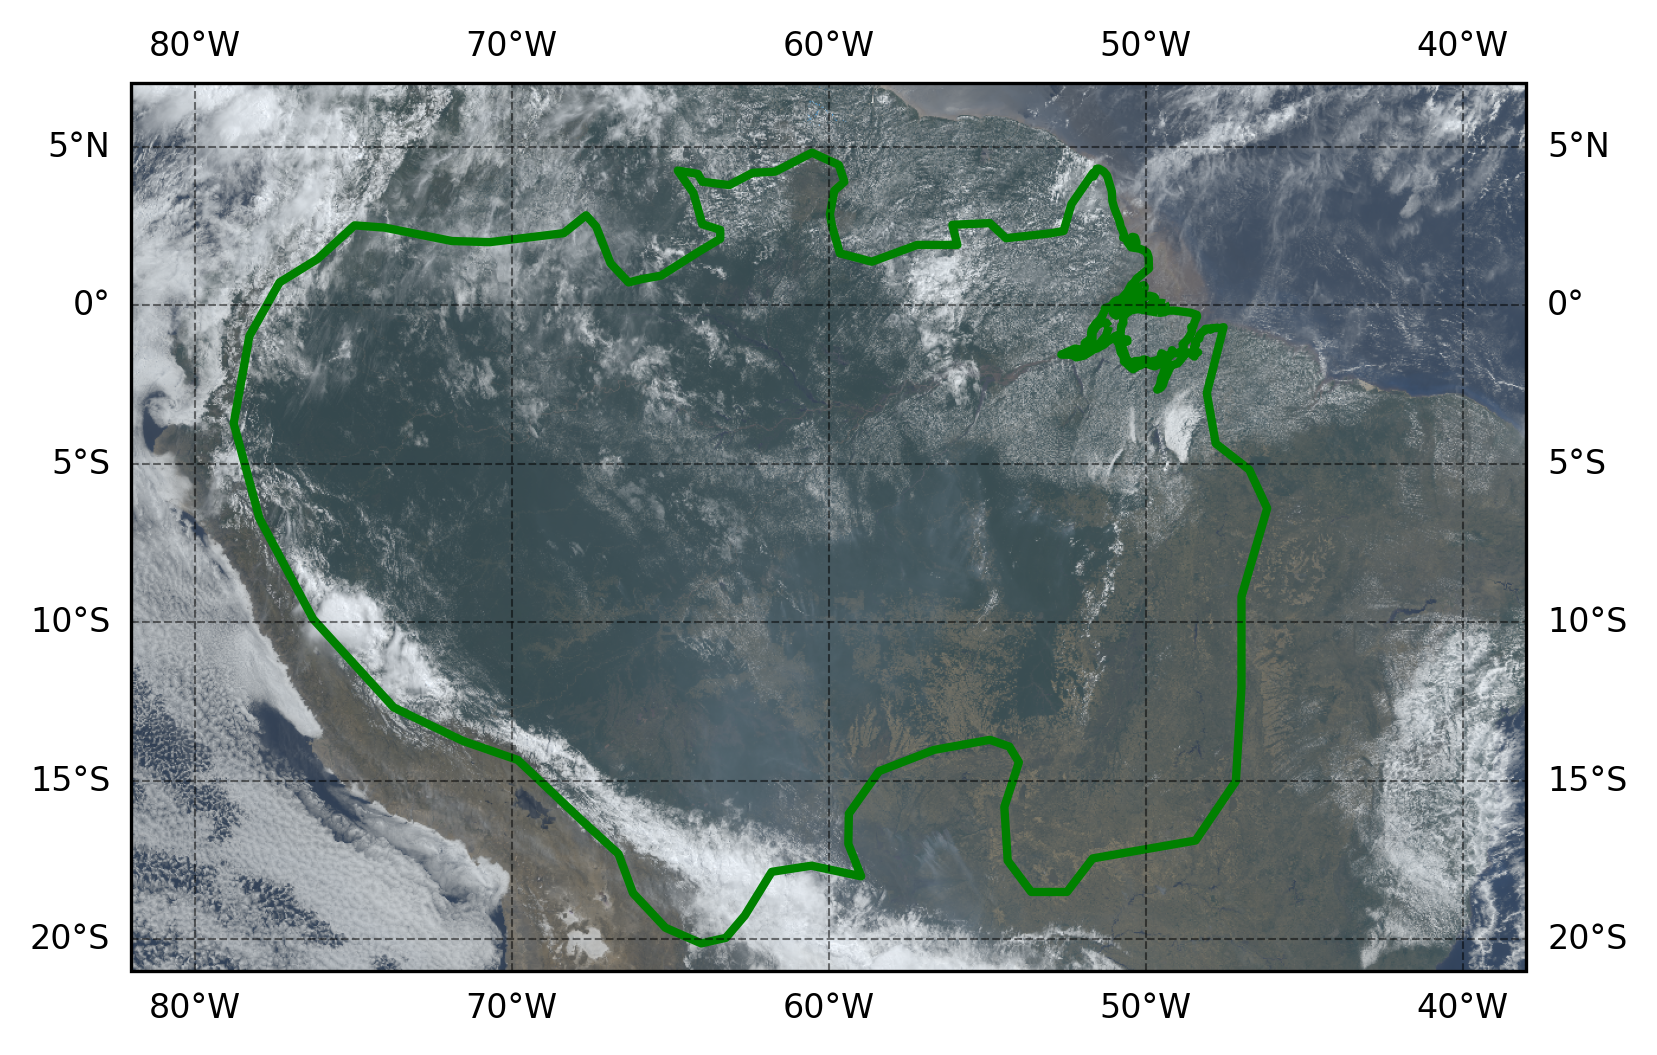

In [15]:
# Define map projection and create the figure
newproj = ccrs.PlateCarree()  # Use PlateCarree projection for the map (regular lat/lon grid)
geo = ccrs.Geodetic()  # Use Geodetic projection for geodesic lines (accurate measurement of distances)
fig = plt.figure(figsize=(6, 4), dpi=300)  # Create a figure with the specified size and high DPI
ax = fig.add_subplot(1, 1, 1, projection=newproj)  # Create a map subplot with the defined projection

# Set the extent of the map (focus on the region of interest with a buffer around the area)
ax.set_extent([minlon, maxlon, minlat, maxlat], crs=newproj)

# Plot the image on the map (RGB image in the correct projection)
ax.imshow(RGB_image, origin='upper', transform=oproj, zorder=1)

# Load and simplify the Amazon basin shapefile (reduce vertices for faster rendering)
os.environ['SHAPE_RESTORE_SHX'] = 'YES'  # Ensure that SHX files are restored for shapefile handling
amazon_basin = gpd.read_file('../Auxiliary Data/amazonbasinjson.shp')  # Read the Amazon basin shapefile
amazon_basin['geometry'] = amazon_basin.geometry.simplify(tolerance=0.01)  # Simplify the geometry to reduce vertices

# Plot the Amazon basin boundary on the map (green boundary with no fill)
amazon_basin.plot(ax=ax, edgecolor='Green', facecolor='none', linewidth=2, zorder=2)

# Add gridlines and labels (customize formatting for longitude and latitude labels)
gl = ax.gridlines(crs=newproj, draw_labels=True, linewidth=0.5, color='black', alpha=0.5, linestyle='--')  # Add gridlines
gl.xlabels_top = False  # Disable top x-axis labels
gl.ylabels_right = False  # Disable right y-axis labels
gl.xformatter = LongitudeFormatter(zero_direction_label=True, number_format='.0f')  # Format longitude labels
gl.yformatter = LatitudeFormatter(number_format='.0f')  # Format latitude labels
gl.xlabel_style = {'size': 8}  # Set font size for x-axis labels
gl.ylabel_style = {'size': 8}  # Set font size for y-axis labels

# Show the plot or save it as an image
plt.show()
# plt.savefig('filename.png', dpi=300, bbox_inches='tight', pad_inches=0.1)  # Save the plot as an image